In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [103]:
# Load the dataset (change path if needed)
df = pd.read_csv(r"C:\Users\suraj\OneDrive\Desktop\LP3-master\ML\datasets\uber.csv")
# Display first 5 rows
df.head()

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


In [104]:
# Remove missing values
df = df.dropna()

# Keep only positive fare values
df = df[df['fare_amount'] > 0]

# Convert pickup_datetime to datetime format
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], errors='coerce')
df = df.dropna(subset=['pickup_datetime'])

# Create a simple distance feature (approximation)
df['distance'] = ((df['dropoff_longitude'] - df['pickup_longitude'])**2 +
                  (df['dropoff_latitude'] - df['pickup_latitude'])**2)**0.5

# Remove rows where distance is 0
df = df[df['distance'] > 0]

print("Data after preprocessing:", df.shape)
df.head()

Data after preprocessing: (194347, 10)


,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06+00:00,-73.999817,40.738354,-73.999512,40.723217,1,0.015140
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56+00:00,-73.994355,40.728225,-73.994710,40.750325,1,0.022103
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00+00:00,-74.005043,40.740770,-73.962565,40.772647,1,0.053109
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21+00:00,-73.976124,40.790844,-73.965316,40.803349,3,0.016528
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00+00:00,-73.925023,40.744085,-73.973082,40.761247,5,0.051031


In [105]:
# Remove extreme outliers using IQR method on fare_amount
Q1 = df['fare_amount'].quantile(0.25)
Q3 = df['fare_amount'].quantile(0.75)
IQR = Q3 - Q1
low = Q1 - 1.5 * IQR
high = Q3 + 1.5 * IQR
df = df[(df['fare_amount'] >= low) & (df['fare_amount'] <= high)]

# Remove unrealistic distance values (greater than 5 degrees ~ 500 km)
df = df[df['distance'] < 0.04]

print("Data after removing outliers:", df.shape)
df.head()

Data after removing outliers: (146319, 10)


,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06+00:00,-73.999817,40.738354,-73.999512,40.723217,1,0.015140
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56+00:00,-73.994355,40.728225,-73.994710,40.750325,1,0.022103
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21+00:00,-73.976124,40.790844,-73.965316,40.803349,3,0.016528
8,15822268,2012-02-17 09:32:00.00000043,9.7,2012-02-17 09:32:00+00:00,-73.975187,40.745767,-74.002720,40.743537,1,0.027623
10,2205147,2015-05-22 17:32:27.0000004,6.5,2015-05-22 17:32:27+00:00,-73.974388,40.746952,-73.988586,40.729805,1,0.022262


Correlation Matrix:
             fare_amount  distance
fare_amount     1.000000  0.702447
distance        0.702447  1.000000


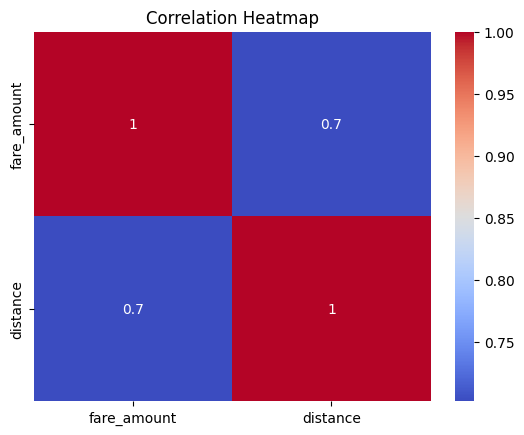

In [106]:
# Select numerical columns for correlation
corr = df[['fare_amount', 'distance']].corr()

# Print correlation
print("Correlation Matrix:")
print(corr)

# Plot heatmap
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()


In [107]:
# Extract time-based features
df['hour'] = df['pickup_datetime'].dt.hour
df['weekday'] = df['pickup_datetime'].dt.weekday
df['month'] = df['pickup_datetime'].dt.month

# Keep only useful columns
df = df[['fare_amount', 'distance', 'hour', 'weekday', 'month']]
df.head()


,fare_amount,distance,hour,weekday,month
0,7.5,0.015140,19,3,5
1,7.7,0.022103,20,4,7
3,5.3,0.016528,8,4,6
8,9.7,0.027623,9,4,2
10,6.5,0.022262,17,4,5


In [108]:
corr = df.corr()
print(corr)

             fare_amount  distance      hour   weekday     month
fare_amount     1.000000  0.702447  0.026125 -0.004165  0.038995
distance        0.702447  1.000000  0.013780  0.023288  0.007521
hour            0.026125  0.013780  1.000000 -0.076056 -0.002268
weekday        -0.004165  0.023288 -0.076056  1.000000 -0.010123
month           0.038995  0.007521 -0.002268 -0.010123  1.000000


In [109]:
# Define features and target
X = df[['distance', 'hour', 'weekday', 'month']]
y = df['fare_amount']

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training data:", X_train.shape)
print("Testing data:", X_test.shape)


Training data: (117055, 4)
Testing data: (29264, 4)


In [110]:
# Scale features for Linear Regression
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

# Train Linear Regression
lr = LinearRegression()
lr.fit(X_train_s, y_train)

# Predict
y_pred_lr = lr.predict(X_test_s)


In [111]:
# Train Random Forest Regressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_s, y_train)

# Predict
y_pred_rf = rf.predict(X_test_s)


In [123]:
# Define evaluation function
def evaluate(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    return round(r2, 4), round(rmse, 2), round(mae, 2)

# Evaluate both models
r2_lr, rmse_lr, mae_lr = evaluate(y_test, y_pred_lr)
r2_rf, rmse_rf, mae_rf = evaluate(y_test, y_pred_rf)

# Create comparison table
results = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest'],
    'R2 Score': [r2_lr, r2_rf],
    'RMSE': [rmse_lr, rmse_rf],
    'MAE': [mae_lr, mae_rf]
})

print("Model Comparison Results:")
display(results)

Model Comparison Results:


,Model,R2 Score,RMSE,MAE
0,Linear Regression,0.4982,2.09,1.47
1,Random Forest,0.4700,2.15,1.53
